In [1]:
%matplotlib inline

In [97]:
import os
import shutil
import datetime

import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, PReLU, LeakyReLU, BatchNormalization, Add, Flatten, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.applications import vgg19

import skimage.draw
from skimage.io import imshow

# Text Localization

"Generative Adversarial Networks (GAN) is one of the most promising recent developments in Deep Learning. GAN, introduced by Ian Goodfellow in 2014, attacks the problem of unsupervised learning by training two deep networks, called `generator` and `discriminator`, that compete and cooperate with each other. In the course of training, both networks eventually learn how to perform their tasks." - [Source](https://towardsdatascience.com/understanding-and-optimizing-gans-going-back-to-first-principles-e5df8835ae18)

GAN models can be used and have shown very good results for image-to-image translation problems, e.g. creating semantic segmentation from image or the reverse, drawing to photo translation, enhancing image resolution and more...

In this project we attempt to segment an image into text and non-text. 
The notebooks are structured as follows:

1. Text Localization (this one).
2. Text Localization without machine learning
3. Text Localization, failing GAN
4. How did the training go?

## Generator

In the context of our task - text localization, the generator attemps to produce a map of the text it sees on the image. 

Other strategies include region proposal networks (RPN).

There are advantages of using an image-to-image translation network. For example there is no limit on the amount of bounding boxes it can produce. And since the generator is fully convolutional it works on images of any size.


## Discriminator

The discriminator's job is to tell how real an image is, and the generator should learn to produce more and more convincing images.

Training a GAN is the hardest part. We first determine if the `discriminator` model is correct by training it alone with real and fake images. Afterwards, the `discriminator` and `adversarial` models are trained one after the other.

### The Images (target and fake)

Before building a model let's read the images and see what we must classify exactly.

We will do training on a data set of scanned receipts. The data set includes the image and a .txt file with a list of rectangles, specifying where there is text on the image.   

In [3]:
BASE_TRAIN_DIR = "./receipt_data/task_1_train"

TRAIN_PCT = .80
VAL_PCT = .10

We list the file names in the folder and then do a train, val, test split.

In [4]:
def read_folder(path):
    result = set()
    
    for file_name in os.listdir(path):
        if "(" in file_name: continue # Skips duplicates
        if "_" in file_name: continue # Skips images created by us (preprocessing)
        if "normalized" in file_name: continue # Skips images created by us (preprocessing)

        base_name, _ = os.path.splitext(file_name)
        result.add(os.path.join(path, base_name))

    return list(result)

In [5]:
def validate(files):
    for base_name in files:
        if not os.path.isfile(base_name + ".jpg"):
            print(f"Error: {base_name}.jpg")
            assert False
        if not os.path.isfile(base_name + ".txt"):
            print(f"Error: {base_name}.txt")
            assert False

In [6]:
train_images = read_folder(BASE_TRAIN_DIR)
validate(train_images) # Validate just makes sure the paths are valid

In [7]:
def train_val_test_split(images):
    images = list(images)
    train_end_index = round(len(images) * TRAIN_PCT)
    val_end_index = train_end_index + round(len(images) * VAL_PCT)
    train = images[:train_end_index]
    val = images[train_end_index:val_end_index]
    test = images[val_end_index:]
    return train, val, test

In [8]:
train_data, val_data, test_data = train_val_test_split(train_images)

Let's visualize the images:

In [23]:
def show_image(img):
    plt.figure(figsize = (8, 8))
    imshow(img)

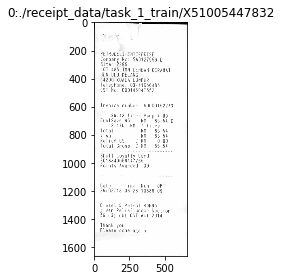

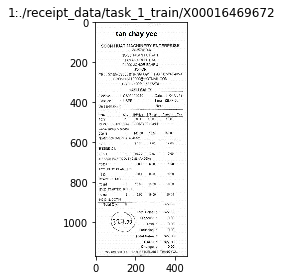

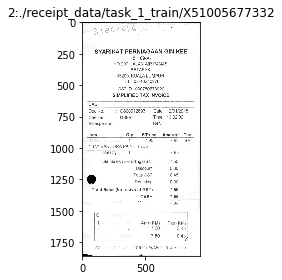

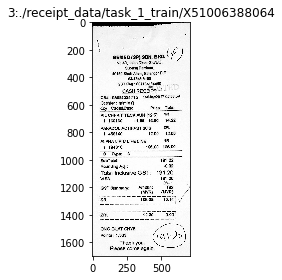

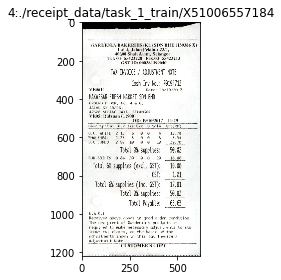

In [10]:
for i in range(5):
    path = train_images[i]
    img_raw = tf.io.read_file(path + ".jpg")
    img = tf.io.decode_jpeg(img_raw)

    plt.title(f"{i}:{path}")
    imshow(img.numpy())
    plt.show()

Let's also see the min/max width and height of all images. We use this information to resize the images to ease the training of the discriminator later. We hope to teach it the difference of the *features* of the map (so losing information in this case doesn't matter - it matters later when we train the generator). 

In [11]:
def get_min_max_dims():
    min_w, max_w, min_h, max_h = 10e7, 0, 10e7, 0

    for i, base_name in enumerate(train_images):
        print(base_name)
        print(f"{i + 1}/{len(train_images)}")

        img_raw = tf.io.read_file(base_name + ".jpg")
        img = tf.io.decode_jpeg(img_raw)

        min_w = min(min_w, img.shape[1])
        max_w = max(max_w, img.shape[1])

        min_h = min(min_h, img.shape[0])
        max_h = max(max_h, img.shape[0])
    return min_w, max_w, min_h, max_h

In [12]:
get_min_max_dims()

./receipt_data/task_1_train/X51005447832
1/623
./receipt_data/task_1_train/X00016469672
2/623
./receipt_data/task_1_train/X51005677332
3/623
./receipt_data/task_1_train/X51006388064
4/623
./receipt_data/task_1_train/X51006557184
5/623
./receipt_data/task_1_train/X51006619342
6/623
./receipt_data/task_1_train/X51006387951
7/623
./receipt_data/task_1_train/X51007225399
8/623
./receipt_data/task_1_train/X51007339131
9/623
./receipt_data/task_1_train/X51006620187
10/623
./receipt_data/task_1_train/X51005757324
11/623
./receipt_data/task_1_train/X51007339162
12/623
./receipt_data/task_1_train/X51005705760
13/623
./receipt_data/task_1_train/X51007846410
14/623
./receipt_data/task_1_train/X51007339115
15/623
./receipt_data/task_1_train/X51007846395
16/623
./receipt_data/task_1_train/X51006389865
17/623
./receipt_data/task_1_train/X51005711456
18/623
./receipt_data/task_1_train/X51005745187
19/623
./receipt_data/task_1_train/X51006556838
20/623
./receipt_data/task_1_train/X51008099102
21/623
.

./receipt_data/task_1_train/X51005605286
171/623
./receipt_data/task_1_train/X51006392273
172/623
./receipt_data/task_1_train/X51007339656
173/623
./receipt_data/task_1_train/X51005757201
174/623
./receipt_data/task_1_train/X51008099043
175/623
./receipt_data/task_1_train/X51005711451
176/623
./receipt_data/task_1_train/X51006555780
177/623
./receipt_data/task_1_train/X51008164420
178/623
./receipt_data/task_1_train/X51005711404
179/623
./receipt_data/task_1_train/X51006619496
180/623
./receipt_data/task_1_train/X51008145505
181/623
./receipt_data/task_1_train/X51007339107
182/623
./receipt_data/task_1_train/X51005303661
183/623
./receipt_data/task_1_train/X51007846270
184/623
./receipt_data/task_1_train/X51006557117
185/623
./receipt_data/task_1_train/X51005719899
186/623
./receipt_data/task_1_train/X51005268400
187/623
./receipt_data/task_1_train/X51008064061
188/623
./receipt_data/task_1_train/X51006466778
189/623
./receipt_data/task_1_train/X51006619566
190/623
./receipt_data/task_

./receipt_data/task_1_train/X51006913031
339/623
./receipt_data/task_1_train/X51006557178
340/623
./receipt_data/task_1_train/X51008123604
341/623
./receipt_data/task_1_train/X51006556732
342/623
./receipt_data/task_1_train/X51006647932
343/623
./receipt_data/task_1_train/X51006556730
344/623
./receipt_data/task_1_train/X51005757273
345/623
./receipt_data/task_1_train/X51006913073
346/623
./receipt_data/task_1_train/X51006008073
347/623
./receipt_data/task_1_train/X51006389888
348/623
./receipt_data/task_1_train/X51006414675
349/623
./receipt_data/task_1_train/X51005806703
350/623
./receipt_data/task_1_train/X51006008057
351/623
./receipt_data/task_1_train/X51005568913
352/623
./receipt_data/task_1_train/X51005453802
353/623
./receipt_data/task_1_train/X51007339167
354/623
./receipt_data/task_1_train/X51006619785
355/623
./receipt_data/task_1_train/X51006557188
356/623
./receipt_data/task_1_train/X51005724554
357/623
./receipt_data/task_1_train/X51005677334
358/623
./receipt_data/task_

./receipt_data/task_1_train/X51007339110
508/623
./receipt_data/task_1_train/X51005663301
509/623
./receipt_data/task_1_train/X51005676544
510/623
./receipt_data/task_1_train/X51005749912
511/623
./receipt_data/task_1_train/X51007339651
512/623
./receipt_data/task_1_train/X51008123447
513/623
./receipt_data/task_1_train/X51006557193
514/623
./receipt_data/task_1_train/X51006913023
515/623
./receipt_data/task_1_train/X51007339111
516/623
./receipt_data/task_1_train/X51005715451
517/623
./receipt_data/task_1_train/X51008142068
518/623
./receipt_data/task_1_train/X51006388044
519/623
./receipt_data/task_1_train/X51006857071
520/623
./receipt_data/task_1_train/X51005444033
521/623
./receipt_data/task_1_train/X51006619765
522/623
./receipt_data/task_1_train/X51008142034
523/623
./receipt_data/task_1_train/X51006389884
524/623
./receipt_data/task_1_train/X51006557195
525/623
./receipt_data/task_1_train/X51006387847
526/623
./receipt_data/task_1_train/X51006387971
527/623
./receipt_data/task_

(436, 4961, 605, 7016)

Now let's see the text annotations in action:

In [13]:
def draw_borders_around_polygons(img, polygons, c = [0, 255, 0]):
    """
    "img" - an RGB image
    "polygons" - list of coordinates in the form [x1, y1, x2, y2, x3, y3, x4, y4]
    "c" - color (green by default)
    """
    img_copy = np.array(img).copy()

    for coords in polygons:
        r, c = [int(c) for c in coords[1::2]], [int(c) for c in coords[::2]]
        rr, cc = skimage.draw.polygon_perimeter(r, c)
        img_copy[rr, cc] = np.array([0, 255, 0])
    return img_copy

The "gaussian map" or the "text localization map" is drawn using a gaussian function instead of just using harsh rectangles.
The hope is that this makes it easier for the generator to learn the relationship between text and the white smoothed rectangles. 

In [14]:
def draw_gaussian_map(img_shape, polygons):
    """
    "img_shape" - we take a look at the first two elements for height/weight
    "polygons" - list of coordinates in the form [x1, y1, x2, y2, x3, y3, x4, y4]
    """
    map = np.zeros((img_shape[0], img_shape[1]))

    for coords in polygons:
        r, c = [int(c) for c in coords[1::2]], [int(c) for c in coords[::2]]
        rr, cc = skimage.draw.polygon(r, c)

        center_y = round(np.mean(rr))
        gaussian_width = (np.max(rr) - np.min(rr)) / 4
        # print(gaussian_width)

        values = (1 / (2 * np.pi * gaussian_width)) * np.e ** (-((rr - center_y) ** 2)/(2 * gaussian_width ** 2))
        values /= np.max(values)
        map[rr, cc] = values
    return map

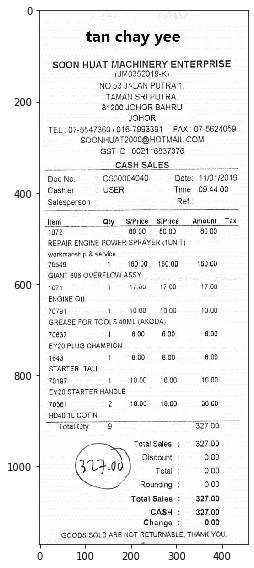

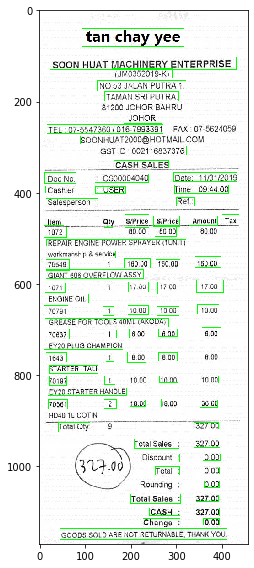

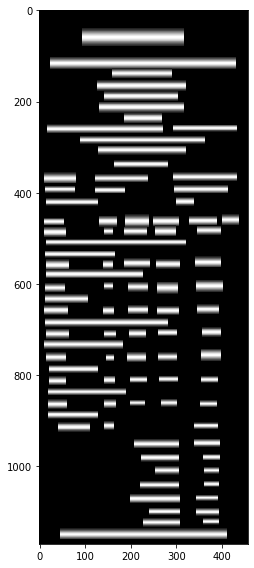

In [15]:
base_name = train_images[1]
img_raw = tf.io.read_file(base_name + ".jpg")

img = tf.io.decode_jpeg(img_raw)
show_image(img.numpy())

with open(base_name + ".txt", encoding = "utf8") as f:
    polygons = [coords for coords in [l.split(",")[:8] for l in f.read().split("\n")] if len(coords) == 8]
img_with_borders = draw_borders_around_polygons(img, polygons)
show_image(img_with_borders)

gaussian_map = draw_gaussian_map(img.shape, polygons)
show_image(gaussian_map)

### Preparing images for training

When working with images preprocessing is mandatory. 

The function below goes through all images and generates the target map (like the black image with white rectangles above). 

It also uses `tf.image.resize_with_pad` in order to ease the training process. Since right now we want to train the discriminator to distinguish between "real" and "fake" maps it's not important if we lose a bit of information.

We also calculate the mean and variances of the pixel values in order to normalize the "original" images later (the ones with the receipts). The normalized images are passed into an untrained generator network in order to produce "fake" images in order to train the discriminator. We take note of the image mean and variance in order to do the same preprocessing later when actually training the generator.

In [9]:
TRAIN_IMAGE_WIDTH = 436
TRAIN_IMAGE_HEIGHT = 605

In [17]:
def preprocess_images(do_targets = True):
    """
    Generates target images from the .txt annotation and saves to disk.
    Resizes the images (with tf.image.resize_with_pad) and saves them to disk.
    Calculates the mean and variance of all pixel values (used later for normalization).
    """
    means = np.zeros((len(train_images), 1, 1, 3))
    variances = np.zeros((len(train_images), 1, 1, 3))
    
    for i, base_name in enumerate(train_images):
        print(base_name)
        print(f"{i + 1}/{len(train_images)}")

        img_raw = tf.io.read_file(base_name + ".jpg")
        img = tf.io.decode_jpeg(img_raw)

        # Generates the target image (gaussian map) from the .txt file annotation, which specifies the target rectangles
        if do_targets:
            with open(base_name + ".txt", encoding = "utf8") as f:
                polygons = [coords for coords in [l.split(",")[:8] for l in f.read().split("\n")] if len(coords) == 8]
        
            gaussian_map = draw_gaussian_map(img.shape, polygons) * 255
            gaussian_map = tf.image.resize_with_pad(np.expand_dims(gaussian_map, axis = 2), TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
            img_to_save = tf.io.encode_jpeg(tf.cast(gaussian_map, dtype = tf.uint8))
            tf.io.write_file(base_name + "_target.jpg", img_to_save)
        
        # Resizes the image and saves it 
        img = tf.image.resize_with_pad(img, TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
        img_to_save = tf.io.encode_jpeg(tf.cast(img, dtype = tf.uint8))
        tf.io.write_file(base_name + "_resized.jpg", img_to_save)
        
        # Calculates statistics used later for normalization
        means[i] = np.mean(img, axis = (0, 1)).reshape([1, 1, 3])
        variances[i] = np.var(img, axis = (0, 1)).reshape([1, 1, 3])

    grand_mean = means.mean(axis = 0)
    
    pooled_variance = np.zeros((1, 1, 3))
    for i in range(len(train_images)):
        pooled_variance += (TRAIN_IMAGE_WIDTH * TRAIN_IMAGE_HEIGHT - 1) * variances[i] # -1 for Bessel's correction
    pooled_variance /= len(train_images) * TRAIN_IMAGE_WIDTH * TRAIN_IMAGE_HEIGHT
    
    return grand_mean, pooled_variance

In [18]:
images_mean, images_variance = preprocess_images()
images_mean, images_variance

./receipt_data/task_1_train/X51005447832
1/623
./receipt_data/task_1_train/X00016469672
2/623
./receipt_data/task_1_train/X51005677332
3/623
./receipt_data/task_1_train/X51006388064
4/623
./receipt_data/task_1_train/X51006557184
5/623
./receipt_data/task_1_train/X51006619342
6/623
./receipt_data/task_1_train/X51005230617
41/623
./receipt_data/task_1_train/X51005676546
42/623
./receipt_data/task_1_train/X51006335547
43/623
./receipt_data/task_1_train/X51007339136
44/623
./receipt_data/task_1_train/X51005442386
45/623
./receipt_data/task_1_train/X51007135247
46/623
./receipt_data/task_1_train/X51006556646
47/623
./receipt_data/task_1_train/X51005442392
48/623
./receipt_data/task_1_train/X51006557202
49/623
./receipt_data/task_1_train/X51005742068
50/623
./receipt_data/task_1_train/X51008042783
51/623
./receipt_data/task_1_train/X51008142005
52/623
./receipt_data/task_1_train/X51005442344
53/623
./receipt_data/task_1_train/X51007339106
54/623
./receipt_data/task_1_train/X51005719882
55/62

./receipt_data/task_1_train/X51006557213
204/623
./receipt_data/task_1_train/X51007103688
205/623
./receipt_data/task_1_train/X51007339132
206/623
./receipt_data/task_1_train/X51005676545
207/623
./receipt_data/task_1_train/X51007846302
208/623
./receipt_data/task_1_train/X51006828217
209/623
./receipt_data/task_1_train/X51006387812
210/623
./receipt_data/task_1_train/X51005605334
211/623
./receipt_data/task_1_train/X51005719886
212/623
./receipt_data/task_1_train/X51006557508
213/623
./receipt_data/task_1_train/X51006008197
214/623
./receipt_data/task_1_train/X51006008091
215/623
./receipt_data/task_1_train/X51006392299
216/623
./receipt_data/task_1_train/X51008123580
217/623
./receipt_data/task_1_train/X51006414636
218/623
./receipt_data/task_1_train/X51005268200
219/623
./receipt_data/task_1_train/X51005676549
220/623
./receipt_data/task_1_train/X51005447853
221/623
./receipt_data/task_1_train/X51005677335
222/623
./receipt_data/task_1_train/X51005677329
223/623
./receipt_data/task_

./receipt_data/task_1_train/X51006414703
372/623
./receipt_data/task_1_train/X51008122920
373/623
./receipt_data/task_1_train/X51006393377
374/623
./receipt_data/task_1_train/X51006401723
375/623
./receipt_data/task_1_train/X51007339113
376/623
./receipt_data/task_1_train/X51005757346
377/623
./receipt_data/task_1_train/X51005568891
378/623
./receipt_data/task_1_train/X51006414470
379/623
./receipt_data/task_1_train/X51007846353
380/623
./receipt_data/task_1_train/X51008114283
381/623
./receipt_data/task_1_train/X51005433514
382/623
./receipt_data/task_1_train/X51005605285
383/623
./receipt_data/task_1_train/X51008145450
384/623
./receipt_data/task_1_train/X51006502533
385/623
./receipt_data/task_1_train/X51009453804
386/623
./receipt_data/task_1_train/X51005444037
387/623
./receipt_data/task_1_train/X51006620161
388/623
./receipt_data/task_1_train/X51006913074
389/623
./receipt_data/task_1_train/X51006555570
390/623
./receipt_data/task_1_train/X51006414671
391/623
./receipt_data/task_

./receipt_data/task_1_train/X51006556650
540/623
./receipt_data/task_1_train/X51007339094
541/623
./receipt_data/task_1_train/X51005444045
542/623
./receipt_data/task_1_train/X51007339117
543/623
./receipt_data/task_1_train/X51005577192
544/623
./receipt_data/task_1_train/X51007339647
545/623
./receipt_data/task_1_train/X51008164999
546/623
./receipt_data/task_1_train/X51005301667
547/623
./receipt_data/task_1_train/X51005447852
548/623
./receipt_data/task_1_train/X51006388069
549/623
./receipt_data/task_1_train/X51006679222
550/623
./receipt_data/task_1_train/X51008099083
551/623
./receipt_data/task_1_train/X51006556726
552/623
./receipt_data/task_1_train/X51005442338
553/623
./receipt_data/task_1_train/X51006619777
554/623
./receipt_data/task_1_train/X51008099087
555/623
./receipt_data/task_1_train/X51005757294
556/623
./receipt_data/task_1_train/X51008063849
557/623
./receipt_data/task_1_train/X51006913055
558/623
./receipt_data/task_1_train/X51005442327
559/623
./receipt_data/task_

(array([[[167.9331281 , 167.92850393, 167.59806013]]]),
 array([[[10780.83383274, 10787.71812415, 10739.68412558]]]))

In [19]:
np.save("images_mean", images_mean)
np.save("images_variance", images_variance)

In [20]:
def normalize_images():
    for i, base_name in enumerate(train_images):
        print(base_name)
        print(f"{i + 1}/{len(train_images)}")

        img_raw = tf.io.read_file(base_name + "_resized.jpg")
        img = tf.io.decode_jpeg(img_raw).numpy().astype(float)
        img -= images_mean
        img /= np.sqrt(images_variance) + 1e-7
        
        np.save(base_name + "_normalized", img)

In [21]:
normalize_images()

./receipt_data/task_1_train/X51005447832
1/623
./receipt_data/task_1_train/X00016469672
2/623
./receipt_data/task_1_train/X51005677332
3/623
./receipt_data/task_1_train/X51006388064
4/623
./receipt_data/task_1_train/X51006557184
5/623
./receipt_data/task_1_train/X51006619342
6/623
./receipt_data/task_1_train/X51006387951
7/623
./receipt_data/task_1_train/X51007225399
8/623
./receipt_data/task_1_train/X51007339131
9/623
./receipt_data/task_1_train/X51006620187
10/623
./receipt_data/task_1_train/X51005757324
11/623
./receipt_data/task_1_train/X51007339162
12/623
./receipt_data/task_1_train/X51005705760
13/623
./receipt_data/task_1_train/X51007846410
14/623
./receipt_data/task_1_train/X51007339115
15/623
./receipt_data/task_1_train/X51007846395
16/623
./receipt_data/task_1_train/X51006389865
17/623
./receipt_data/task_1_train/X51005711456
18/623
./receipt_data/task_1_train/X51005745187
19/623
./receipt_data/task_1_train/X51006556838
20/623
./receipt_data/task_1_train/X51008099102
21/623
.

./receipt_data/task_1_train/X51005605286
171/623
./receipt_data/task_1_train/X51006392273
172/623
./receipt_data/task_1_train/X51007339656
173/623
./receipt_data/task_1_train/X51005757201
174/623
./receipt_data/task_1_train/X51008099043
175/623
./receipt_data/task_1_train/X51005711451
176/623
./receipt_data/task_1_train/X51006555780
177/623
./receipt_data/task_1_train/X51008164420
178/623
./receipt_data/task_1_train/X51005711404
179/623
./receipt_data/task_1_train/X51006619496
180/623
./receipt_data/task_1_train/X51008145505
181/623
./receipt_data/task_1_train/X51007339107
182/623
./receipt_data/task_1_train/X51005303661
183/623
./receipt_data/task_1_train/X51007846270
184/623
./receipt_data/task_1_train/X51006557117
185/623
./receipt_data/task_1_train/X51005719899
186/623
./receipt_data/task_1_train/X51005268400
187/623
./receipt_data/task_1_train/X51008064061
188/623
./receipt_data/task_1_train/X51006466778
189/623
./receipt_data/task_1_train/X51006619566
190/623
./receipt_data/task_

./receipt_data/task_1_train/X51006913031
339/623
./receipt_data/task_1_train/X51006557178
340/623
./receipt_data/task_1_train/X51008123604
341/623
./receipt_data/task_1_train/X51006556732
342/623
./receipt_data/task_1_train/X51006647932
343/623
./receipt_data/task_1_train/X51006556730
344/623
./receipt_data/task_1_train/X51005757273
345/623
./receipt_data/task_1_train/X51006913073
346/623
./receipt_data/task_1_train/X51006008073
347/623
./receipt_data/task_1_train/X51006389888
348/623
./receipt_data/task_1_train/X51006414675
349/623
./receipt_data/task_1_train/X51005806703
350/623
./receipt_data/task_1_train/X51006008057
351/623
./receipt_data/task_1_train/X51005568913
352/623
./receipt_data/task_1_train/X51005453802
353/623
./receipt_data/task_1_train/X51007339167
354/623
./receipt_data/task_1_train/X51006619785
355/623
./receipt_data/task_1_train/X51006557188
356/623
./receipt_data/task_1_train/X51005724554
357/623
./receipt_data/task_1_train/X51005677334
358/623
./receipt_data/task_

./receipt_data/task_1_train/X51006856981
507/623
./receipt_data/task_1_train/X51007339110
508/623
./receipt_data/task_1_train/X51005663301
509/623
./receipt_data/task_1_train/X51005676544
510/623
./receipt_data/task_1_train/X51005749912
511/623
./receipt_data/task_1_train/X51007339651
512/623
./receipt_data/task_1_train/X51008123447
513/623
./receipt_data/task_1_train/X51006557193
514/623
./receipt_data/task_1_train/X51006913023
515/623
./receipt_data/task_1_train/X51007339111
516/623
./receipt_data/task_1_train/X51005715451
517/623
./receipt_data/task_1_train/X51008142068
518/623
./receipt_data/task_1_train/X51006388044
519/623
./receipt_data/task_1_train/X51006857071
520/623
./receipt_data/task_1_train/X51005444033
521/623
./receipt_data/task_1_train/X51006619765
522/623
./receipt_data/task_1_train/X51008142034
523/623
./receipt_data/task_1_train/X51006389884
524/623
./receipt_data/task_1_train/X51006557195
525/623
./receipt_data/task_1_train/X51006387847
526/623
./receipt_data/task_

In [22]:
!ls ./receipt_data/task_1_train

X00016469612_fake.npy	     X51006414703_normalized.npy
X00016469612.jpg	     X51006414703normalized.npy
X00016469612_normalized.npy  X51006414703_resized.jpg
X00016469612normalized.npy   X51006414703_target.jpg
X00016469612_resized.jpg     X51006414703.txt
X00016469612_target.jpg      X51006414711_fake.npy
X00016469612.txt	     X51006414711.jpg
X00016469619_fake.npy	     X51006414711_normalized.npy
X00016469619.jpg	     X51006414711normalized.npy
X00016469619_normalized.npy  X51006414711_resized.jpg
X00016469619normalized.npy   X51006414711_target.jpg
X00016469619_resized.jpg     X51006414711.txt
X00016469619_target.jpg      X51006414712_fake.npy
X00016469619.txt	     X51006414712.jpg
X00016469620_fake.npy	     X51006414712_normalized.npy
X00016469620.jpg	     X51006414712normalized.npy
X00016469620_normalized.npy  X51006414712_resized.jpg
X00016469620normalized.npy   X51006414712_target.jpg
X00016469620_resized.jpg     X51006414712.txt
X00016469620_target.jpg      X51006414713_fake.np

X51006389865.txt	     X51008123599_target.jpg
X51006389884_fake.npy	     X51008123599.txt
X51006389884.jpg	     X51008123604_fake.npy
X51006389884_normalized.npy  X51008123604.jpg
X51006389884normalized.npy   X51008123604_normalized.npy
X51006389884_resized.jpg     X51008123604normalized.npy
X51006389884_target.jpg      X51008123604_resized.jpg
X51006389884.txt	     X51008123604_target.jpg
X51006389888_fake.npy	     X51008123604.txt
X51006389888.jpg	     X51008128052_fake.npy
X51006389888_normalized.npy  X51008128052.jpg
X51006389888normalized.npy   X51008128052_normalized.npy
X51006389888_resized.jpg     X51008128052normalized.npy
X51006389888_target.jpg      X51008128052_resized.jpg
X51006389888.txt	     X51008128052_target.jpg
X51006389893_fake.npy	     X51008128052.txt
X51006389893.jpg	     X51008128062_fake.npy
X51006389893_normalized.npy  X51008128062.jpg
X51006389893normalized.npy   X51008128062_normalized.npy
X51006389893_resized.jpg     X51008128062normalized.npy
X51006389893_

In [23]:
base_name = train_images[1]
img = np.load(base_name + "_normalized.npy")
img.mean(), img.std()

(-0.3730375686133958, 1.1825386529732818)

The last cell shows the image normalization taking place.

The architecture of the generator is described elsewhere. Here we just run through the images and save them to disk in order to save time. We could actually make a dataset with just the images paths and make a mapping function which does all the preprocessing, but then the training would take absolutely ages.

* Note: Right now we are running the generator in order to pre-train the discriminator. In reality all the preprocessing we need to do to an image is normalization and resizing. 

In [24]:
generator_model = tf.keras.models.load_model("generator_untrained")

In [25]:
def create_fake_images_for_discriminator_using_untrained_generator():
    for i, base_name in enumerate(train_images):
        print(base_name)
        print(f"{i + 1}/{len(train_images)}")
        
        img = np.load(path + "_normalized.npy")
        predicted = generator_model(tf.expand_dims(img, axis = 0))[0]
        np.save(base_name + "_fake", predicted.numpy())

In [ ]:
create_fake_images_for_discriminator_using_untrained_generator()

An example of a text map on the untrained generator:

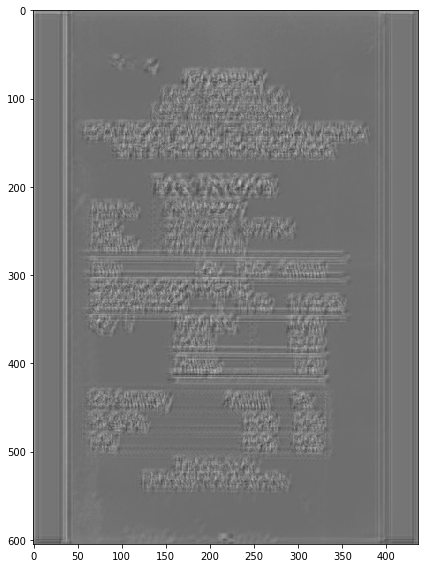

In [26]:
base_name = train_images[1]
img = np.load(base_name + "_fake.npy")
show_image(np.squeeze(img))

### Discriminator model architecture

We do transfer learning with VGG19. The pretrained model extracts features from the image. A proper text localization map should be black and contain white where there should be text (like in the visualization above).

In [64]:
tf.keras.backend.clear_session()

In [65]:
vgg19_pretrained = vgg19.VGG19(include_top = False)
vgg19_pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [66]:
for l in vgg19_pretrained.layers:
    l.trainable = False

Even though our text localization map has one channel only, VGG expects 3 channels per image. When feeding the image we convert it to RGB. The rest of the architecture is just three arbitrary dense layers with `Dropout` normalization. 

In [67]:
DISCRIMINATOR_WIDTH = 128
DISCRIMINATOR_HEIGHT = 128

In [68]:
discriminator_model = Sequential([
    Input(shape = (DISCRIMINATOR_HEIGHT, DISCRIMINATOR_WIDTH, 3)), 
    vgg19_pretrained,
    Flatten(),
    Dense(256, activation = "relu"), 
    Dropout(0.1),
    Dense(20, activation = "relu"),
    Dropout(0.1),
    Dense(1, activation = "sigmoid")
])
discriminator_model.compile()
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

Now when training we load all the images into memory. We do this because we can, however if training on a larger dataset then this might be infeasible. In any case we create a `tf.data.Dataset` in order to map the image labels and also to combine and shuffle the fake and real images before training.

In [17]:
def read_images_into_memory(paths):
    fake = np.zeros((len(paths), TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH, 3)).astype(np.float32)
    real = np.zeros((len(paths), TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH, 3)).astype(np.float32)

    for i, path in enumerate(paths):
        print(path)
        print(f"{i + 1}/{len(paths)}")
        
        fake[i] = np.load(path + "_fake.npy")
        
        img_raw = tf.io.read_file(path + "_target.jpg")
        real[i] = tf.io.decode_jpeg(img_raw)
        real[i] /= 255 # Transform pixel values from 0-255 to 0-1.
    return fake, real

In [18]:
fake_train, real_train = read_images_into_memory(train_data)
fake_val, real_val = read_images_into_memory(val_data)
fake_test, real_test = read_images_into_memory(test_data)

./receipt_data/task_1_train/X51006556656
1/498
./receipt_data/task_1_train/X51006556818
2/498
./receipt_data/task_1_train/X51005749895
3/498
./receipt_data/task_1_train/X51006414703
4/498
./receipt_data/task_1_train/X51005676540
5/498
./receipt_data/task_1_train/X51006620190
6/498
./receipt_data/task_1_train/X51008042783
7/498
./receipt_data/task_1_train/X51006555806
8/498
./receipt_data/task_1_train/X51007339135
9/498
./receipt_data/task_1_train/X51005663273
10/498
./receipt_data/task_1_train/X51005447853
11/498
./receipt_data/task_1_train/X51006335552
12/498
./receipt_data/task_1_train/X51006327978
13/498
./receipt_data/task_1_train/X51008099048
14/498
./receipt_data/task_1_train/X51008142059
15/498
./receipt_data/task_1_train/X51005711451
16/498
./receipt_data/task_1_train/X51006556838
17/498
./receipt_data/task_1_train/X51005433541
18/498
./receipt_data/task_1_train/X51006466055
19/498
./receipt_data/task_1_train/X51005719874
20/498
./receipt_data/task_1_train/X51006335314
21/498
.

./receipt_data/task_1_train/X51005722699
171/498
./receipt_data/task_1_train/X51007339106
172/498
./receipt_data/task_1_train/X51006388069
173/498
./receipt_data/task_1_train/X51006466062
174/498
./receipt_data/task_1_train/X51008123447
175/498
./receipt_data/task_1_train/X51007135247
176/498
./receipt_data/task_1_train/X51006857071
177/498
./receipt_data/task_1_train/X51008099089
178/498
./receipt_data/task_1_train/X51005442397
179/498
./receipt_data/task_1_train/X51007579726
180/498
./receipt_data/task_1_train/X51005719917
181/498
./receipt_data/task_1_train/X51005605334
182/498
./receipt_data/task_1_train/X51006328919
183/498
./receipt_data/task_1_train/X51008142031
184/498
./receipt_data/task_1_train/X51005568900
185/498
./receipt_data/task_1_train/X51006414431
186/498
./receipt_data/task_1_train/X51009453804
187/498
./receipt_data/task_1_train/X51006620161
188/498
./receipt_data/task_1_train/X51005447860
189/498
./receipt_data/task_1_train/X51008164996
190/498
./receipt_data/task_

./receipt_data/task_1_train/X51007103643
339/498
./receipt_data/task_1_train/X51005711456
340/498
./receipt_data/task_1_train/X51005757248
341/498
./receipt_data/task_1_train/X51008114282
342/498
./receipt_data/task_1_train/X51006387971
343/498
./receipt_data/task_1_train/X51006619545
344/498
./receipt_data/task_1_train/X51008042778
345/498
./receipt_data/task_1_train/X51006619777
346/498
./receipt_data/task_1_train/X51005677339
347/498
./receipt_data/task_1_train/X51005301667
348/498
./receipt_data/task_1_train/X51006557164
349/498
./receipt_data/task_1_train/X00016469672
350/498
./receipt_data/task_1_train/X51006556604
351/498
./receipt_data/task_1_train/X51005715456
352/498
./receipt_data/task_1_train/X51007339651
353/498
./receipt_data/task_1_train/X51006389963
354/498
./receipt_data/task_1_train/X51006556839
355/498
./receipt_data/task_1_train/X51006557178
356/498
./receipt_data/task_1_train/X51006466066
357/498
./receipt_data/task_1_train/X51007225398
358/498
./receipt_data/task_

./receipt_data/task_1_train/X51006311764
10/62
./receipt_data/task_1_train/X51006414519
11/62
./receipt_data/task_1_train/X51005447833
12/62
./receipt_data/task_1_train/X51006556823
13/62
./receipt_data/task_1_train/X51008123476
14/62
./receipt_data/task_1_train/X51007339648
15/62
./receipt_data/task_1_train/X51006008197
16/62
./receipt_data/task_1_train/X51006556738
17/62
./receipt_data/task_1_train/X51005715010
18/62
./receipt_data/task_1_train/X51005719904
19/62
./receipt_data/task_1_train/X00016469676
20/62
./receipt_data/task_1_train/X51005719882
21/62
./receipt_data/task_1_train/X51006620191
22/62
./receipt_data/task_1_train/X51007846393
23/62
./receipt_data/task_1_train/X51006679222
24/62
./receipt_data/task_1_train/X51006327976
25/62
./receipt_data/task_1_train/X51006008073
26/62
./receipt_data/task_1_train/X51005711452
27/62
./receipt_data/task_1_train/X51008123450
28/62
./receipt_data/task_1_train/X51006414485
29/62
./receipt_data/task_1_train/X51005711441
30/62
./receipt_dat

And now we make sure we've prepared everything correctly. Thoroughly. Because programmers love making mistakes :).

In [19]:
fake_train.shape, real_train.shape, fake_val.shape, real_val.shape, fake_test.shape, real_test.shape

((498, 605, 436, 3),
 (498, 605, 436, 3),
 (62, 605, 436, 3),
 (62, 605, 436, 3),
 (63, 605, 436, 3),
 (63, 605, 436, 3))

In [20]:
fake_train.min(), real_train.min(), fake_val.min(), real_val.min(), fake_test.min(), real_test.min()

(0.24379894, 0.0, 0.24379894, 0.0, 0.24379894, 0.0)

In [21]:
fake_train.max(), real_train.max(), fake_val.max(), real_val.max(), fake_test.max(), real_test.max()

(0.76894784, 1.0, 0.76894784, 1.0, 0.76894784, 1.0)

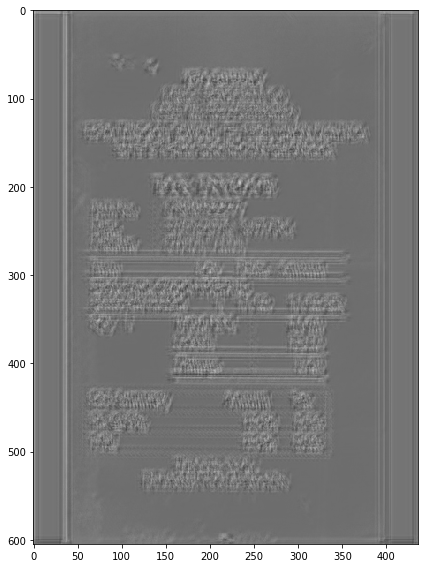

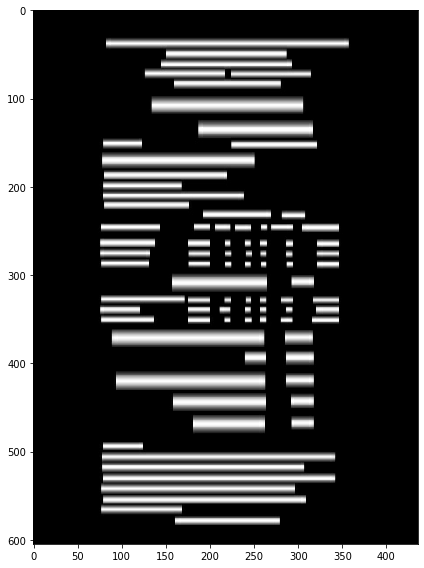

In [24]:
show_image(fake_train[0])
show_image(real_train[0])

In [92]:
def map_fake_image(img):
    img = tf.image.resize(img, (DISCRIMINATOR_HEIGHT, DISCRIMINATOR_WIDTH))
    return img, 0

def map_real_image(img):
    img = tf.image.resize(img, (DISCRIMINATOR_HEIGHT, DISCRIMINATOR_WIDTH))
    return img, 1

In [93]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 100

In [94]:
def get_discriminator_datasets():
    fake_image_train = tf.data.Dataset.from_tensor_slices(fake_train)
    fake_image_train = fake_image_train.map(map_fake_image).batch(BATCH_SIZE)

    fake_image_val = tf.data.Dataset.from_tensor_slices(fake_val)
    fake_image_val = fake_image_val.map(map_fake_image).batch(BATCH_SIZE)

    fake_image_test = tf.data.Dataset.from_tensor_slices(fake_test)
    fake_image_test = fake_image_test.map(map_fake_image).batch(BATCH_SIZE)
    
    real_image_train = tf.data.Dataset.from_tensor_slices(real_train)
    real_image_train = real_image_train.map(map_real_image).batch(BATCH_SIZE)

    real_image_val = tf.data.Dataset.from_tensor_slices(real_val)
    real_image_val = real_image_val.map(map_real_image).batch(BATCH_SIZE)

    real_image_test = tf.data.Dataset.from_tensor_slices(real_test)
    real_image_test = real_image_test.map(map_real_image).batch(BATCH_SIZE)
    
    train = real_image_train.concatenate(fake_image_train).shuffle(SHUFFLE_BUFFER_SIZE)
    val = real_image_val.concatenate(fake_image_val).shuffle(SHUFFLE_BUFFER_SIZE)
    test = real_image_test.concatenate(fake_image_test).shuffle(SHUFFLE_BUFFER_SIZE)
    return train, val, test

In [95]:
discriminator_train, discriminator_val, discriminator_test = get_discriminator_datasets()

When doing classification tasks, we usually encounter the following problems: overfitting, and overconfidence. Label smoothing is a regularization technique that addresses both problems. For this model we choose `0.2`.

Our metric is binary accuracy with default threshold of `0.5`.

In [98]:
discriminator_model.compile(loss = BinaryCrossentropy(label_smoothing = 0.2), 
                            optimizer = Adam(),
                            metrics = [BinaryAccuracy()])

In [102]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoints_new_arch/", save_freq = 100 * 3) # Every 3 epochs

discriminator_model.fit(discriminator_train, 
                        validation_data = discriminator_val,
                        epochs = 10,
                        callbacks = [tensorboard_callback, cp_callback])

In [100]:
discriminator_model.evaluate(discriminator_val)

14/14 [==============================] - 7s 451ms/step - loss: 0.3270 - binary_accuracy: 1.0000


[0.3270198404788971, 1.0]

In [101]:
discriminator_model.evaluate(discriminator_test)

14/14 [==============================] - 7s 466ms/step - loss: 0.3271 - binary_accuracy: 1.0000


[0.3270711302757263, 1.0]

In [103]:
discriminator_model.save("discriminator_new_arch_trained")

INFO:tensorflow:Assets written to: discriminator_new_arch_trained/assets


Even though the accuracy is 100%, the difference between fake and real images is staggering. It's really an easy problem (for now, at least until the generator starts to fool the discriminator).

Now it's time to try adversarial training!

## References

* "TLGAN: Document Text Localization Using GAN", Dongyoung Kim, Myungsung Kwak, Eunji Won, Sejung Shin, Jeongyeon Nam, 2020, https://arxiv.org/pdf/2010.11547.pdf
* "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network", Christian Ledig, Lucas Theis, Ferenc Huszar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi, 2016, https://arxiv.org/abs/1609.04802
* "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", Sergey Ioffe, Christian Szegedy, 2015, https://arxiv.org/abs/1502.03167
* "Deep Residual Learning for Image Recognition", Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, 2015, https://arxiv.org/abs/1512.03385


* "Building a ResNet in Keras", Dorian Lazar, 2020, https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba 
* "What is label smoothing?", Wanshun Wong, 2019, https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06
* "GAN by example using Keras", Rowel Atienza, 2017, https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0


* https://en.wikipedia.org/wiki/Pooled_variance
* https://en.wikipedia.org/wiki/Grand_mean